In [1]:
import os, glob, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import simpleicp
import napari
from set_axes_equal import *
import pyclesperanto_prototype as cle

from skimage.filters import threshold_otsu, gaussian
from skimage.feature import peak_local_max
from skimage.io import imread, imsave

from register_icp import *
from optireg import *
from tqdm.notebook import tqdm

import pickle

%matplotlib notebook

# Select image folder

In [2]:
folder = os.path.join('Y:','/Kerim_Anlas/gastruloid_imaging/tracking_preprocess/preprocess/20211117_ESLmix_72h_good','Pos1')
# folder = os.path.join('Y:','/Kerim_Anlas/gastruloid_imaging/tracking_preprocess/preprocess/20211125_ESLmix_72h_good','Pos1_goodbutdense')

### PARAMETERS for registration
available_channels = ['mKO2', 'GFP'] # available channels (folders)
pixel_size = (2,0.3467,0.3467) # anistotropic pixel size (ordered: ZYX)
reference_channel = 'mKO2' # channel used to extract anchor points
cell_diameter_XY = 10 # in pixels
reverse_order = True # process from last timepoint to first (i.e. register all images relative to last frame)
isotropic = True # scale image to isotropic ZYX resolution (i.e. convert Z pixel to be equal to XY pixel)
gpu_down = 1. # scale image down to use less GPU memory and improve speed

# Find all tif files in the folder

In [3]:
flist = glob.glob(os.path.join(folder, reference_channel, '*.tif'))
flist.sort()
# flist = flist[:10]
print('Found %d images.'%len(flist))

Found 200 images.


# Find anchor points

In [4]:
scale = pixel_size[0]/pixel_size[1]
print('Pixel size in Z : %.5f um'%pixel_size[0])
print('Pixel size in XY: %.5f um'%pixel_size[1])
print('Anisotropy: %.5f'%scale)

5.768676088837612


In [5]:
# compute anchor points or load file if it already exists
df = find_anchor_points(folder, flist, fileName = 'anchor_points.csv', 
                        scale = scale, gpu_down = gpu_down, 
                        cell_diameter_XY = cell_diameter_XY, isotropic = isotropic,
                        reverse_order = reverse_order)

In [8]:
df

tp      z      y       x  z_iso
0        0   23.0  699.0   572.0   23.0
1        0   32.0  684.0   717.0   32.0
2        0   38.0  712.0  1022.0   38.0
3        0   42.0  714.0   597.0   42.0
4        0   43.0  736.0   670.0   43.0
...    ...    ...    ...     ...    ...
30455  199  302.0  749.0  1032.0  302.0
30456  199  303.0  316.0   336.0  303.0
30457  199  313.0  376.0   870.0  313.0
30458  199  320.0  209.0   560.0  320.0
30459  199  324.0  851.0   345.0  324.0

[30460 rows x 5 columns]

# Optional: Visualize anchor points

In [ ]:
start = 5
stop = 10
visualize_images = False

#######################################
if visualize_images:
    img = np.array([imread(f) for f in flist[start:stop]])

df_napari = df[(df.tp>=start)&(df.tp<stop)][['tp','z','y','x']].to_numpy()
df_napari[:,0] -= start

viewer = napari.Viewer()
if visualize_images:
    viewer.add_image(img, scale=(scale,1,1), name='gastruloid')
viewer.add_points(df_napari, name='cells', opacity=1., 
                  face_color='red')
napari.run()


<IPython.core.display.Javascript object>


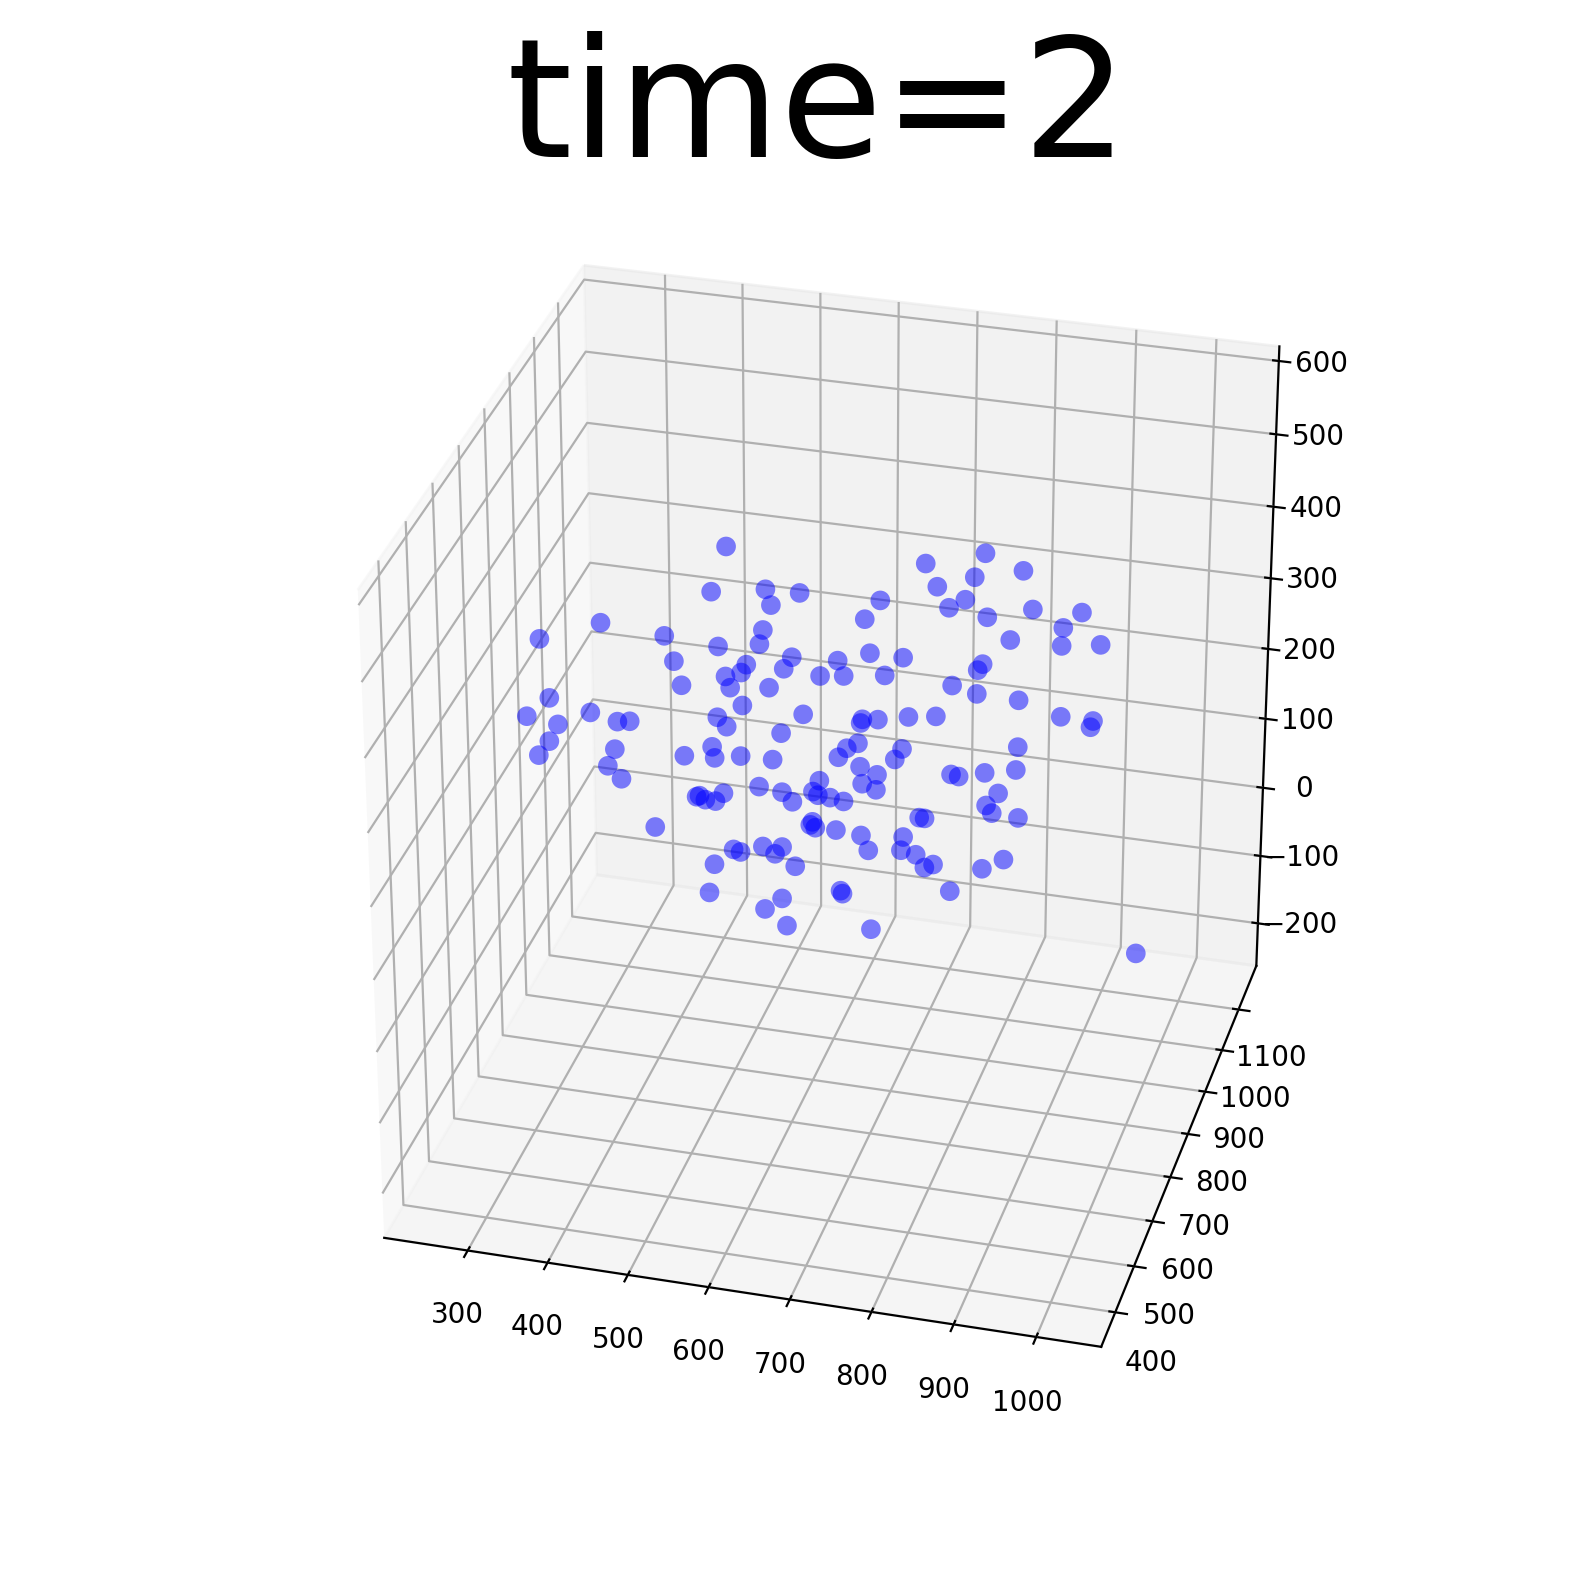

In [9]:
from matplotlib import animation

def visualize_tl_cells(df, elev=30, azim_init=-75, interval=20, cmap='plasma'):
    from matplotlib.animation import FuncAnimation
    ### visualize development from cell tracks

    t_idx = list(set(df.tp))
    t_idx.sort()
    
    cells_tp = df[df.tp==0]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    scatter1 = ax.scatter(cells_tp.x, cells_tp.y, cells_tp.z, linewidth=0, s=50, 
                             alpha=.5, color='b')
    title = ax.set_title('time={}'.format(0), fontsize=60)

    ax.set_box_aspect([1,1,1])
    set_axes_equal(ax)
    ax.view_init(elev=elev, azim=azim_init)
    
    def update(frame):
        cells_tp = df[df.tp==frame]
        t = cells_tp.tp.values[0]
        scatter1._offsets3d = (cells_tp.x, cells_tp.y, cells_tp.z)

        title.set_text('time={}'.format(t))
        
    ani = FuncAnimation(fig, update, len(t_idx), 
                                  interval=interval, blit=False)
    
    return ani

ani = visualize_tl_cells(df, elev=30, azim_init=-75, interval=300)
# writervideo = animation.FFMpegWriter(fps=6) 
# ani.save('cells_TP.gif', dpi=150, writer='imagemagick')



# method: minimize average distance to closest point

In [10]:
tps = list(set(df.tpreg))
tps.sort()
df_list = [df[df.tpreg==tp] for tp in tps]

Ts = find_transformations(df_list, maxiter=100, tol=1e-5)

C:\Users\nicol\AppData\Local\Temp\ipykernel_25120\2842845286.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['xreg'] = np.array(df1[i]['x'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_25120\2842845286.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = np.array(df1[i]['y'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_25120\2842845286.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

  0%|          | 0/199 [00:00<?, ?it/s]

In [11]:
df_list = perform_transofrmations(df_list, Ts)

C:\Users\nicol\AppData\Local\Temp\ipykernel_25120\1786340542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['zreg'] = A[:,0]
C:\Users\nicol\AppData\Local\Temp\ipykernel_25120\1786340542.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = A[:,1]
C:\Users\nicol\AppData\Local\Temp\ipykernel_25120\1786340542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

<IPython.core.display.Javascript object>


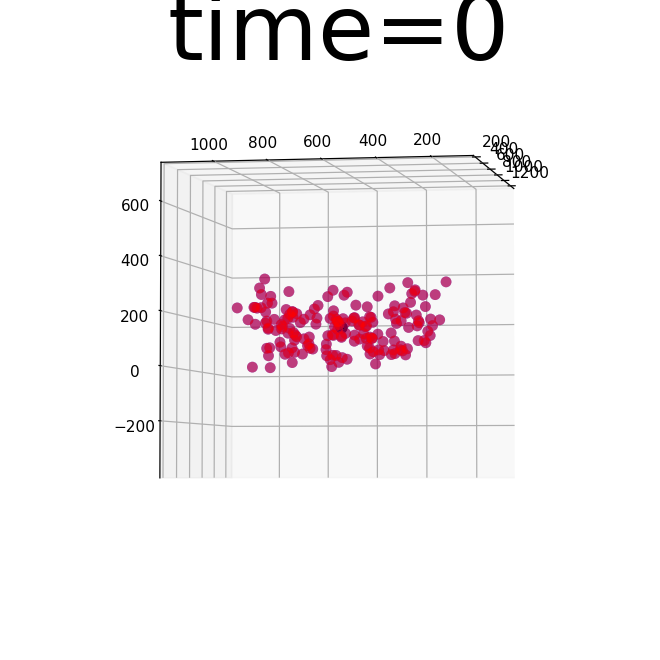

In [14]:
from matplotlib import animation
df_new = pd.concat(df1)#[:10])

def visualize_tl_cells(df2, elev=30, azim_init=-75, interval=20, cmap='plasma'):
    from matplotlib.animation import FuncAnimation
    ### visualize development from cell tracks

    t_idx = list(set(df2.tp))
    t_idx.sort()
    
    cells_tp = df2[df2.tp==0]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')

    scatter1 = ax.scatter(cells_tp.x, cells_tp.y, cells_tp.z, linewidth=0, s=50, 
                             alpha=.5, color='b')
    scatter2 = ax.scatter(cells_tp.xreg, cells_tp.yreg, cells_tp.zreg, linewidth=0, s=50, 
                             alpha=.5, color='r')
    scatter3 = ax.scatter([np.mean(cells_tp.xreg)],
                          [np.mean(cells_tp.yreg)],
                          [np.mean(cells_tp.zreg)], s=50, color='k')
    title = ax.set_title('time={}'.format(0), fontsize=60)

    ax.set_box_aspect([1,1,1])
    set_axes_equal(ax)
    ax.view_init(elev=elev, azim=azim_init)
    
    def update(frame):
        cells_tp = df2[df2.tp==frame]
        t = cells_tp.tp.values[0]
        scatter1._offsets3d = (cells_tp.x, cells_tp.y, cells_tp.z)
        scatter2._offsets3d = (cells_tp.xreg, cells_tp.yreg, cells_tp.zreg)
        scatter3._offsets3d = ([np.mean(cells_tp.xreg)],
                          [np.mean(cells_tp.yreg)],
                          [np.mean(cells_tp.zreg)])

        title.set_text('time={}'.format(t))
        
    ani = FuncAnimation(fig, update, len(t_idx), 
                                  interval=interval, blit=False)
    
    return ani

ani = visualize_tl_cells(df_new, elev=30, azim_init=-75, interval=100)
# writervideo = animation.FFMpegWriter(fps=6) 
# ani.save('cells_TP.gif', dpi=150, writer='imagemagick')



In [12]:
import napari

# img = np.array([imread(f) for f in flist[start:stop]])

df_napari = []
for df_tp in df1:
    poss = df_tp[['tp','z','y','x']].to_numpy()
    for p in poss:
        df_napari.append(p)
df_napari = np.array(df_napari)

df_napari1 = []
for df_tp in df1:
    poss = df_tp[['tp','zreg','yreg','xreg']].to_numpy()
    for p in poss:
        df_napari1.append(p)
df_napari1 = np.array(df_napari1)

viewer = napari.Viewer()
viewer.add_points(df_napari, name='cells', opacity=1, 
#                   scale=(1,1,1),
                  face_color='red')
viewer.add_points(df_napari1, name='cells_reg', opacity=1, 
#                   scale=(1,1,1),
                  face_color='blue')
napari.run()

# method: ICP correspondence

In [43]:
tps = list(set(df.tpreg))
tps.sort()
df1 = [df[df.tpreg==tp] for tp in tps]
features = [None for tp in tps]
n_neighbours = 3
max_dist = 100

### first compute the features for every point
# this is the euclidean distance to the 3 closest points
# and the euclidean distances between them, to give a 6D feature vector for every point
for i in tqdm(range(len(df1))):
    pos = df1[i][['z','y','x']].to_numpy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours+1, algorithm='ball_tree').fit(pos)
    distances, indices = nbrs.kneighbors(pos)

    featuresnow = np.zeros((pos.shape[0],np.sum([n_neighbours-i for i in range(n_neighbours)])))
    
    for j in range(indices.shape[0]):
        ds = [0 for i in range(np.sum([n_neighbours-i for i in range(n_neighbours)]))]
        n=0
        for k in range(indices[j].shape[0]):
#             if j==0:
#                 print(k, indices[j][k])
            for l in range(indices[j][(k+1):].shape[0]):
#                 if j==0:
#                     print('\t', l, indices[j][(k+1):][l])
                d = np.linalg.norm([pos[indices[j][(k+1):][l]]-pos[indices[j][k]]])
                ds[n] = d
                n+=1
        
        featuresnow[j] = np.array(ds)

    features[i] = featuresnow

### next, find the corresponding points between consecutive frames
### based on the 6D feature space.
correspondences = [None for i in range(len(df1)-1)]
for i in tqdm(range(len(df1)-1)):
    pos_ant = df1[i][['z','y','x']].to_numpy()
    pos_now = df1[i+1][['z','y','x']].to_numpy()
    feat_ant = features[i]
    feat_now = features[i+1]
    
    ### for every point in the previous tp, find the matching one in the next tp
    
    # find the point within R from target point with smallest distance in feature space
    d_feature1 = np.array([0. for j in range(pos_ant.shape[0])])
    indices1 = np.array([0 for j in range(pos_ant.shape[0])])
    for j in range(pos_ant.shape[0]):
        d_feat = []
        idx_prel = []
        for k in range(pos_now.shape[0]):
            # compute feature distance for all points in sphere
            if np.linalg.norm(pos_ant[j]-pos_now[k])<max_dist:
                d_feat.append(np.linalg.norm(feat_ant[j]-feat_now[k]))
                idx_prel.append(k)
        if len(d_feat)>0:
            # find point with closest feature distance
            d_feature1[j] = np.min(d_feat)
            idx = idx_prel[np.where(d_feat==np.min(d_feat))[0][0]]
            indices1[j] = idx
        else:
            # no points in sphere
            d_feature1[j] = 1e9
            indices1[j] = -1
        
#     nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(feat_now)
#     d_feature1, indices1 = nbrs.kneighbors(feat_ant)
#     indices1 = indices1[:,0]
#     d_feature1 /= np.sum([n_neighbours-i for i in range(n_neighbours)])
# #     print(pos_ant.shape, pos_now.shape, indices1_prel.shape)
        
    # filter for the N best matching points
    d_feature_thr = np.max(sorted(d_feature1.ravel())[:11])
    indices_ant =  [j for j in range(len(indices1)) if d_feature1[j]<d_feature_thr ]
    indices_now  = [indices1[j] for j in range(len(indices1)) if d_feature1[j]<d_feature_thr ]
    
#     # filter for the M closest points 
#     # (there might be some random matches, and we expect short displacements between consecutive frames)
#     indices_ant_filt = []
#     indices_now_filt = []
#     d_spaces = []
#     for j,k in zip(indices_ant, indices_now):
#         d_space = np.linalg.norm([pos_now[k]-pos_ant[j]])
#         d_spaces.append(d_space)
#     d_space_thr = np.max(sorted(d_spaces)[:5])#np.mean(sorted(d_spaces[:5]))
#     for n in range(len(indices_ant)):
#         j = indices_ant[n]
#         k = indices_now[n]
#         if d_spaces[n]<=d_space_thr:
#             indices_ant_filt.append(j)
#             indices_now_filt.append(k)
            
    indices_ant_filt = indices_ant
    indices_now_filt = indices_now
    
    # build the correspondence matrix: [[0,x],[1,y],...,[N,z]] 
    # where N is the number of points in the previous tp
    # and x,y,...,z represent the index of the matching cell in the current tp
    correspondences[i] = np.array([[j,k] for j,k in zip(indices_ant_filt,indices_now_filt)])

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


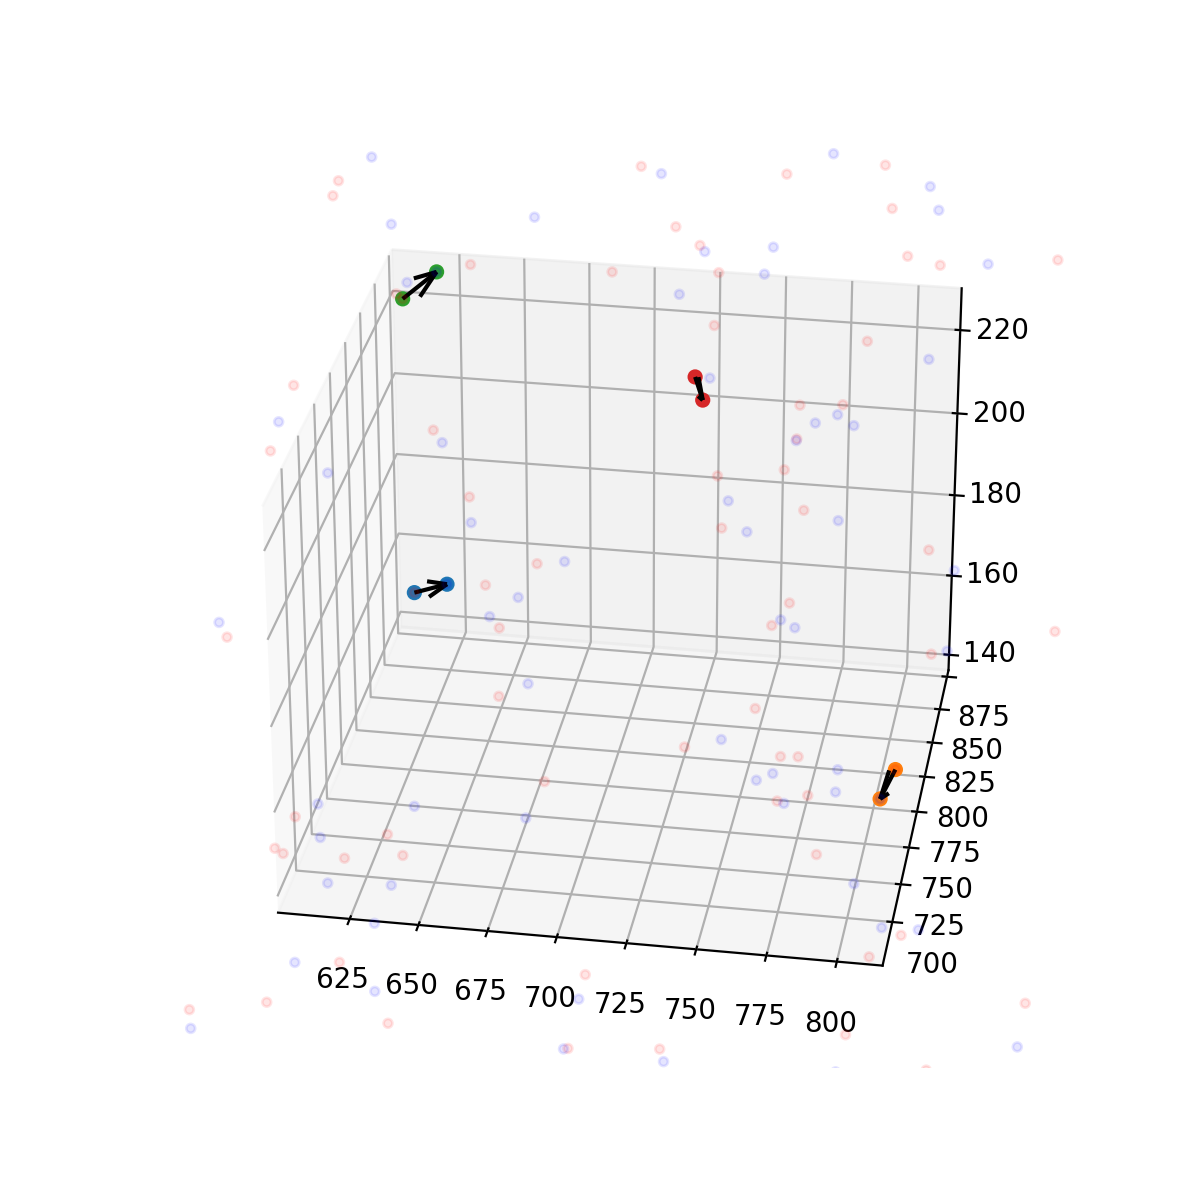

In [42]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# for i in range(0,len(df1)-1,50):
i = 1

pos1 = df1[i][['z','y','x']].to_numpy()
pos1_c = pos1[correspondences[i][:,0]]

pos2 = df1[i+1][['z','y','x']].to_numpy()
pos2_c = pos2[correspondences[i][:,1]]

ax.scatter(pos1[:,2], pos1[:,1], pos1[:,0], color='r', s=10, alpha=0.1)
ax.scatter(pos2[:,2], pos2[:,1], pos2[:,0], color='b', s=10, alpha=0.1)

for j in range(pos1_c.shape[0]):#p1, p2 in zip(pos1,pos2):
    p1 = pos1_c[j]
    p2 = pos2_c[j]
    ax.scatter(
        [p1[2],p2[2]],
        [p1[1],p2[1]],
        [p1[0],p2[0]],
        alpha=1.
    )
    ax.quiver(p1[2], p1[1], p1[0], p2[2]-p1[2], p2[1]-p1[1], p2[0]-p1[0], 
              color='k',
              arrow_length_ratio = .6)

In [38]:
### compute transformation with ICP - 3D

tps = list(set(df.tpreg))
tps.sort()
df1 = [df[df.tpreg==tp] for tp in tps]
Ts = [np.eye(4) for i in range(len(df1))]
for i in range(len(df1)):
    df1[i]['xreg'] = np.array(df1[i]['x'])
    df1[i]['yreg'] = np.array(df1[i]['y'])
    df1[i]['zreg'] = np.array(df1[i]['z'])

for i in tqdm(range(len(df1)-1)):
#     print('Target:',i,'Source:',i+1)

    a = df1[i][['z','y','x']].to_numpy()
    b = df1[i+1][['z','y','x']].to_numpy()
    
    
    a1 = a[correspondences[i][:,0]]
    b1 = b[correspondences[i][:,1]]
    

#     T, distances, _, error_history = icp(b1, a1, max_iterations=100000, tolerance=1e-16)
    T, _, _ = best_fit_transform(b1, a1)
    
#     cm_a = np.mean(a,0)
#     cm_b = np.mean(b,0)
#     cm_T = np.eye(4)
#     cm_T[:3,3] = -(cm_b-cm_a)
#     T = cm_T@T

#     b2 = cloud_transform(b,T)
    
    Ts[i+1] = T
    
#     c = p2.clone().applyTransform(T).points()
for i in range(len(df1)):

    A = df1[i][['z','y','x']].to_numpy()

    T = np.eye(4)
    for j in range(i,0,-1):
        T = np.dot(Ts[j],T)
    A = cloud_transform(A, T)

    df1[i]['zreg'] = A[:,0]
    df1[i]['yreg'] = A[:,1]
    df1[i]['xreg'] = A[:,2]



C:\Users\gritti\AppData\Local\Temp/ipykernel_4996/2341407017.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['xreg'] = np.array(df1[i]['x'])
C:\Users\gritti\AppData\Local\Temp/ipykernel_4996/2341407017.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = np.array(df1[i]['y'])
C:\Users\gritti\AppData\Local\Temp/ipykernel_4996/2341407017.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

  0%|          | 0/187 [00:00<?, ?it/s]

C:\Users\gritti\AppData\Local\Temp/ipykernel_4996/2341407017.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['zreg'] = A[:,0]
C:\Users\gritti\AppData\Local\Temp/ipykernel_4996/2341407017.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = A[:,1]
C:\Users\gritti\AppData\Local\Temp/ipykernel_4996/2341407017.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

<IPython.core.display.Javascript object>


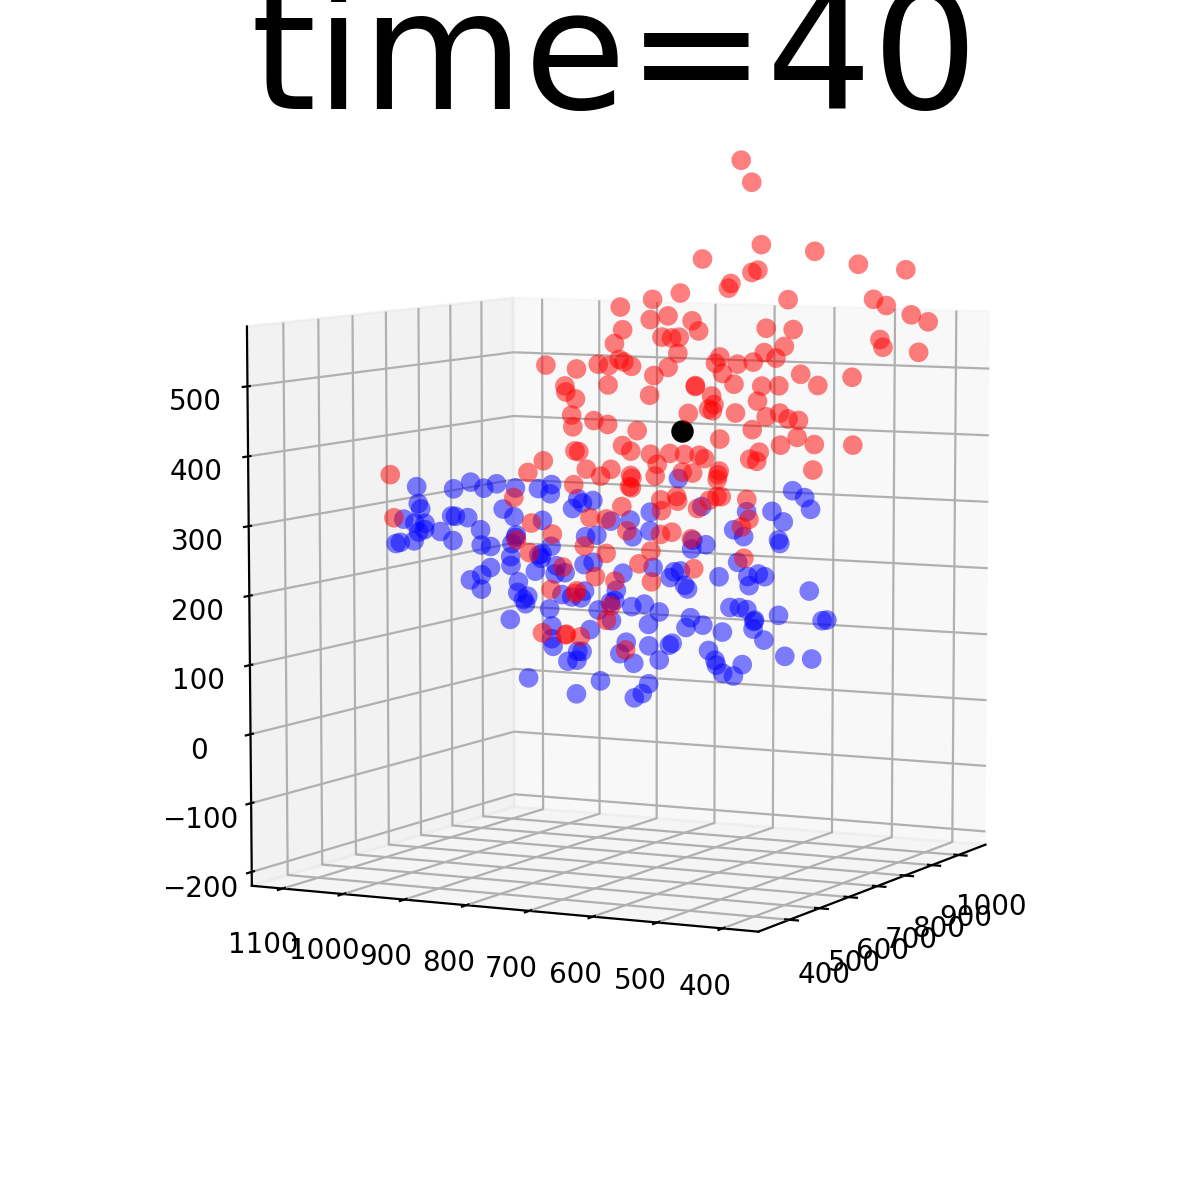

In [39]:
from matplotlib import animation
df_new = pd.concat(df1)#[:10])

def visualize_tl_cells(df2, elev=30, azim_init=-75, interval=20, cmap='plasma'):
    from matplotlib.animation import FuncAnimation
    ### visualize development from cell tracks

    t_idx = list(set(df2.tp))
    t_idx.sort()
    
    cells_tp = df2[df2.tp==0]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')

    scatter1 = ax.scatter(cells_tp.x, cells_tp.y, cells_tp.z, linewidth=0, s=50, 
                             alpha=.5, color='b')
    scatter2 = ax.scatter(cells_tp.xreg, cells_tp.yreg, cells_tp.zreg, linewidth=0, s=50, 
                             alpha=.5, color='r')
    scatter3 = ax.scatter([np.mean(cells_tp.xreg)],
                          [np.mean(cells_tp.yreg)],
                          [np.mean(cells_tp.zreg)], s=50, color='k')
    title = ax.set_title('time={}'.format(0), fontsize=60)

    ax.set_box_aspect([1,1,1])
    set_axes_equal(ax)
    ax.view_init(elev=elev, azim=azim_init)
    
    def update(frame):
        cells_tp = df2[df2.tp==frame]
        t = cells_tp.tp.values[0]
#         scatter1._offsets3d = (cells_tp.x, cells_tp.y, cells_tp.z)
        scatter2._offsets3d = (cells_tp.xreg, cells_tp.yreg, cells_tp.zreg)
        scatter3._offsets3d = ([np.mean(cells_tp.xreg)],
                          [np.mean(cells_tp.yreg)],
                          [np.mean(cells_tp.zreg)])

        title.set_text('time={}'.format(t))
        
    ani = FuncAnimation(fig, update, len(t_idx), 
                                  interval=interval, blit=False)
    
    return ani

ani = visualize_tl_cells(df_new, elev=30, azim_init=-75, interval=100)
# writervideo = animation.FFMpegWriter(fps=6) 
# ani.save('cells_TP.gif', dpi=150, writer='imagemagick')



# with Vedo

In [27]:
# # in a single step, relative to previous tp

# import vtk
# import vedo

# ### compute transformation with ICP - 3D

# tps = list(set(df.tp))
# df1 = [df[df.tp==tp] for tp in tps]
# Ts = [np.eye(4) for i in range(len(df1))]
# for i in range(len(df1)):
#     df1[i]['xreg'] = np.array(df1[i]['x'])
#     df1[i]['yreg'] = np.array(df1[i]['y'])
#     df1[i]['zreg'] = np.array(df1[i]['z'])

# for i in tqdm(range(len(df1)-1)):
# #     print('Target:',i-1,'Source:',i)

#     a = df1[i][['z','y','x']].to_numpy()
#     b = df1[i+1][['z','y','x']].to_numpy()
    
#     ### using vedo
#     p1 = vedo.Points(a)
#     p2 = vedo.Points(b)
    
# #     p1 = vedo.removeOutliers(p1, 1000, neighbors=5)
# #     p2 = vedo.removeOutliers(p2, 1000, neighbors=5)
    
#     # translate point clouds to the center
#     cm1 = p1.centerOfMass()
#     cm2 = p2.centerOfMass()
#     t1 = np.eye(4)
#     t1[:3,3] = cm1
#     t2 = np.eye(4)
#     t2[:3,3] = cm2    
    
#     p1 = p1.clone().applyTransform(np.linalg.inv(t1))
#     p2 = p2.clone().applyTransform(np.linalg.inv(t2))

#     # align point clouds
# #     p2 = p2.alignTo(p1, invert=False, rigid=True, useCentroids=False, iters=10)

#     r = np.eye(4)
# #     p2.transform.GetMatrix().DeepCopy(r.ravel(), p2.transform.GetMatrix())
    
#     # translate aligned cloud to the center
# #     cm2_1 = p2.centerOfMass()    
#     t2_1 = np.eye(4)
# #     t2_1[:3,3] = cm2_1
    
# #     p2 = p2.clone().applyTransform(np.linalg.inv(t2_1))

#     # elign ellipsoid versors
#     e1 = vedo.pcaEllipsoid(p1,pvalue=0.95)
#     versors1 = np.eye(4)
#     versors1[:3,:3] = np.array([vedo.versor(e1.axis1),
#                   vedo.versor(e1.axis2),
#                   vedo.versor(e1.axis3),])
#     e2 = vedo.pcaEllipsoid(p2,pvalue=0.95)
#     versors2 = np.eye(4)
#     versors2[:3,:3] = np.array([vedo.versor(e2.axis1),
#                   vedo.versor(e2.axis2),
#                   vedo.versor(e2.axis3),])
#     versors = versors1@np.linalg.inv(versors2)
    
#     p2 = p2.clone().applyTransform(np.linalg.inv(versors2))
#     p2 = p2.clone().applyTransform(versors1)

#     # translate aligned cloud to the center
# #     cm2_2 = p2.centerOfMass()    
#     t2_2 = np.eye(4)
# #     t2_2[:3,3] = cm2_2
    
#     p2 = p2.clone().applyTransform(np.linalg.inv(t2_2))

#     # compose final transformation combining all steps:
#     # in order: inv(t2), r, inv(t2_1), inv(v2), v1, t1
# #     T = t1@versors1@np.linalg.inv(versors2)@r@np.linalg.inv(t2)#np.dot(t1,t21,np.linalg.inv(t2))
# #     T = t1@r@np.linalg.inv(t2)#np.dot(t1,t21,np.linalg.inv(t2))
# #         t1@versors1@np.linalg.inv(versors2)@r@np.linalg.inv(t2)
#     T = t1@np.linalg.inv(t2_2)@versors@np.linalg.inv(t2_1)@r@np.linalg.inv(t2)

#     # force alignement of ellipsoid
# #     cm2_mat = np.array([[1,0,0,-cm2[0]],[0,1,0,-cm2[1]],[0,0,1,-cm2[2]],[0,0,0,1]])
# #     t21_trans = np.linalg.inv(cm2_mat)@t21@cm2_mat
# #     T = np.dot(t21_trans,T)
        
# #         print(cm)


# #     ### using simpleicp
# #     T = simpleicp.simpleicp(a, b)
# #     cm = np.mean(b,0) - np.mean(a,0)
# #     T[:3,3] += -cm
# # #     T = decompose_rot(T)
    
#     Ts[i+1] = T
    
# for i in range(len(df1)):

#     p1 = df1[i][['z','y','x']].to_numpy()
#     p2 = vedo.Points(p1)

#     T = np.eye(4)
#     for j in range(i,0,-1):
#         T = np.dot(Ts[j],T)
        
#     c1 = cloud_transform(p1, T)

#     df1[i]['zreg'] = c1[:,0]
#     df1[i]['yreg'] = c1[:,1]
#     df1[i]['xreg'] = c1[:,2]
    
#     c2 = p2.clone().applyTransform(T).points()
    
#     df1[i]['zreg1'] = c2[:,0]
#     df1[i]['yreg1'] = c2[:,1]
#     df1[i]['xreg1'] = c2[:,2]



C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\2485003053.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['xreg'] = np.array(df1[i]['x'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\2485003053.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = np.array(df1[i]['y'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\2485003053.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

  0%|          | 0/199 [00:00<?, ?it/s]

C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\2485003053.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['zreg'] = c1[:,0]
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\2485003053.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = c1[:,1]
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\2485003053.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [12]:
# # in a single step, relative to previous tp

# import vtk
# import vedo

# ### compute transformation with ICP - 3D

# tps = list(set(df.tp))
# df1 = [df[df.tp==tp] for tp in tps]
# Ts = [np.eye(4) for i in range(len(df1))]
# for i in range(len(df1)):
#     df1[i]['xreg'] = np.array(df1[i]['x'])
#     df1[i]['yreg'] = np.array(df1[i]['y'])
#     df1[i]['zreg'] = np.array(df1[i]['z'])

# for i in tqdm(range(len(df1)-1)):
# #     print('Target:',i-1,'Source:',i)

#     a = df1[i][['z','y','x']].to_numpy()
#     b = df1[i+1][['z','y','x']].to_numpy()
    
#     ### using vedo
#     p1 = vedo.Points(a)
#     p2 = vedo.Points(b)
    
#     p1 = vedo.removeOutliers(p1, 1000, neighbors=5)
#     p2 = vedo.removeOutliers(p2, 1000, neighbors=5)
    
#     # translate into

#     cm1 = p1.centerOfMass()
#     cm2 = p2.centerOfMass()
#     cm21 = cm2-cm1
    
#     t1 = np.eye(4)
#     t1[:3,3] = cm1
#     t2 = np.eye(4)
#     t2[:3,3] = cm2    
    
#     p1 = p1.applyTransform(np.linalg.inv(t1))
#     p2 = p2.applyTransform(np.linalg.inv(t2))

# #     p2 = p2.alignTo(p1, invert=False, rigid=True, useCentroids=True, iters=1000)

#     r = np.eye(4)
# #     p2.transform.GetMatrix().DeepCopy(r.ravel(), p2.transform.GetMatrix())

#     e1 = vedo.pcaEllipsoid(p1,pvalue=0.95)
#     versors1 = np.eye(4)
#     versors1[:3,:3] = np.array([vedo.versor(e1.axis1),
#                   vedo.versor(e1.axis2),
#                   vedo.versor(e1.axis3),])
#     e2 = vedo.pcaEllipsoid(p2,pvalue=0.95)
#     versors2 = np.eye(4)
#     versors2[:3,:3] = np.array([vedo.versor(e2.axis1),
#                   vedo.versor(e2.axis2),
#                   vedo.versor(e2.axis3),])
    
#     # force center of mass
#     T = t1@versors1@np.linalg.inv(versors2)@r@np.linalg.inv(t2)#np.dot(t1,t21,np.linalg.inv(t2))
# #     T = t1@r@np.linalg.inv(t2)#np.dot(t1,t21,np.linalg.inv(t2))

#     # force alignement of ellipsoid
# #     cm2_mat = np.array([[1,0,0,-cm2[0]],[0,1,0,-cm2[1]],[0,0,1,-cm2[2]],[0,0,0,1]])
# #     t21_trans = np.linalg.inv(cm2_mat)@t21@cm2_mat
# #     T = np.dot(t21_trans,T)
        
# #         print(cm)


# #     ### using simpleicp
# #     T = simpleicp.simpleicp(a, b)
# #     cm = np.mean(b,0) - np.mean(a,0)
# #     T[:3,3] += -cm
# # #     T = decompose_rot(T)
    
#     Ts[i+1] = T
    
# for i in range(len(df1)):

#     p1 = df1[i][['z','y','x']].to_numpy()
#     p2 = vedo.Points(p1)

#     T = np.eye(4)
#     for j in range(i,0,-1):
#         T = np.dot(Ts[j],T)
        
#     c1 = cloud_transform(p1, T)

#     df1[i]['zreg'] = c1[:,0]
#     df1[i]['yreg'] = c1[:,1]
#     df1[i]['xreg'] = c1[:,2]
    
#     c2 = p2.clone().applyTransform(T).points()
    
#     df1[i]['zreg1'] = c2[:,0]
#     df1[i]['yreg1'] = c2[:,1]
#     df1[i]['xreg1'] = c2[:,2]



C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\3345189698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['xreg'] = np.array(df1[i]['x'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\3345189698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = np.array(df1[i]['y'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\3345189698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

  0%|          | 0/199 [00:00<?, ?it/s]

C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\3345189698.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['zreg'] = c1[:,0]
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\3345189698.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i]['yreg'] = c1[:,1]
C:\Users\nicol\AppData\Local\Temp\ipykernel_24460\3345189698.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

<IPython.core.display.Javascript object>


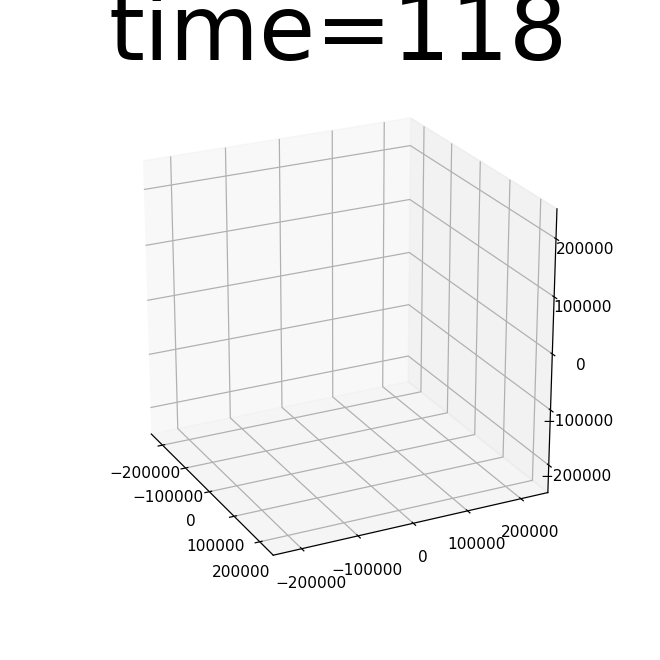

In [28]:
# from matplotlib import animation
# df_new = pd.concat(df1)#[:10])

# def visualize_tl_cells(df2, elev=30, azim_init=-75, interval=20, cmap='plasma'):
#     from matplotlib.animation import FuncAnimation
#     ### visualize development from cell tracks

#     t_idx = list(set(df2.tp))
#     t_idx.sort()
    
#     cells_tp = df2[df2.tp==0]
#     fig = plt.figure(figsize=(6,6))
#     ax = fig.add_subplot(projection='3d')

# #     scatter1 = ax.scatter(cells_tp.x, cells_tp.y, cells_tp.z, linewidth=0, s=50, 
# #                              alpha=.5, color='b')
# #     scatter2 = ax.scatter(cells_tp.xreg, cells_tp.yreg, cells_tp.zreg, linewidth=0, s=50, 
# #                              alpha=.5, color='r')
#     scatter3 = ax.scatter(cells_tp.xreg1, cells_tp.yreg1, cells_tp.zreg1, linewidth=0, s=50, 
#                              alpha=.5, color='g')
#     scatter4 = ax.scatter([np.mean(cells_tp.xreg1)],
#                           [np.mean(cells_tp.yreg1)],
#                           [np.mean(cells_tp.zreg1)], s=50, color='k')
#     title = ax.set_title('time={}'.format(0), fontsize=60)

#     ax.set_box_aspect([1,1,1])
#     set_axes_equal(ax)
#     ax.view_init(elev=elev, azim=azim_init)
    
#     def update(frame):
#         cells_tp = df2[df2.tp==frame]
#         t = cells_tp.tp.values[0]
# #         scatter1._offsets3d = (cells_tp.x, cells_tp.y, cells_tp.z)
# #         scatter2._offsets3d = (cells_tp.xreg, cells_tp.yreg, cells_tp.zreg)
#         scatter3._offsets3d = (cells_tp.xreg1, cells_tp.yreg1, cells_tp.zreg1)
#         scatter4._offsets3d = ([np.mean(cells_tp.xreg1)],
#                           [np.mean(cells_tp.yreg1)],
#                           [np.mean(cells_tp.zreg1)])

#         title.set_text('time={}'.format(t))
        
#     ani = FuncAnimation(fig, update, len(t_idx), 
#                                   interval=interval, blit=False)
    
#     return ani

# ani = visualize_tl_cells(df_new, elev=30, azim_init=-75, interval=100)
# # writervideo = animation.FFMpegWriter(fps=6) 
# # ani.save('cells_TP.gif', dpi=150, writer='imagemagick')



# Perform image registration

In [ ]:
for channel in available_channels:
    print(channel)

    infolder = os.path.join(folder, channel)
    flist = glob.glob(os.path.join(infolder, '*.tif'))
    flist.sort()
    if reverse_order:
        flist = flist[::-1]

    outfolder = os.path.join(folder,channel+'_reg1')

    img = imread(flist[0])
    shape = np.array([img.shape[0], img.shape[1], img.shape[2]])
    pad = (shape*0.0).astype(int)

    if not os.path.exists(os.path.join(outfolder)):
            os.mkdir(os.path.join(outfolder))
    for mip_folder in ['MIP_XY','MIP_YZ','MIP_XZ']:
        if not os.path.exists(os.path.join(outfolder,mip_folder)):
            os.mkdir(os.path.join(outfolder,mip_folder))
    for mip_folder in ['MIP_XY','MIP_YZ','MIP_XZ']:
        if not os.path.exists(os.path.join(infolder,mip_folder)):
            os.mkdir(os.path.join(infolder,mip_folder))

    i=0
    for f in tqdm(flist, total=len(flist)):
        fname = os.path.split(f)[-1]

#         if not os.path.exists(os.path.join(outfolder,'t%04d.tif'%(i+1))):

        img_input = imread(f)
    
        #make isotropic
        img = cle.create([int(img_input.shape[0] * scale), 
                                int(img_input.shape[1]), 
                                int(img_input.shape[2])])
        cle.scale(img_input, img, factor_x=1, factor_y=1, factor_z=scale, centered=False)
        
        if not os.path.exists(os.path.join(infolder,'MIP_XY','t%04d.tif'%(i+1))):
            imsave(os.path.join(infolder,'MIP_XY',fname),
                   np.max(img.astype(np.uint16),0),
                   check_contrast=False)
        if not os.path.exists(os.path.join(infolder,'MIP_XZ','t%04d.tif'%(i+1))):
            imsave(os.path.join(infolder,'MIP_XZ',fname),
                   np.max(img.astype(np.uint16),1),
                   check_contrast=False)
        if not os.path.exists(os.path.join(infolder,'MIP_YZ','t%04d.tif'%(i+1))):
            imsave(os.path.join(infolder,'MIP_YZ',fname),
                   np.max(img.astype(np.uint16),2),
                   check_contrast=False)
        
        img = np.pad(img, [[p,p] for p in pad])

        T = np.eye(4)
        for j in range(i,0,-1):
            T = np.dot(Ts[j],T)
#         T = Ts[i]

        img_reg_iso = image_transform(img,np.linalg.inv(T),order=0,origin=pad)
        img_reg = cle.create([int(img_reg_iso.shape[0] / scale), 
                                int(img_reg_iso.shape[1]), 
                                int(img_reg_iso.shape[2])])
        cle.scale(img_reg_iso, img_reg, factor_x=1, factor_y=1, factor_z=1/scale, centered=False)
        
        imsave(os.path.join(outfolder,fname),
               img_reg.astype(np.uint16),
               check_contrast=False)

        imsave(os.path.join(outfolder,'MIP_XY',fname),
               np.max(img_reg,0).astype(np.uint16),
               check_contrast=False)
        imsave(os.path.join(outfolder,'MIP_XZ',fname),
               np.max(img_reg,1).astype(np.uint16),
               check_contrast=False)
        imsave(os.path.join(outfolder,'MIP_YZ',fname),
               np.max(img_reg,2).astype(np.uint16),
               check_contrast=False)

        i += 1


mKO2


  0%|          | 0/200 [00:00<?, ?it/s]